# Insights of Hyderabad, India

## Table of Contents 

- Introduction
- Data Collection from APIs
- Data Cleaning
- Methodolgy
- Analysis
- Results and Discussion
- Conclusion

## Introduction

The aim of the project is to identify various venues in Hyderabad,India based on their rating and average prices. In this notebook we will use Foursquare and Zomato APIs to identify various venues in Hyderabad and conclude which restaurant suits them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.


## Data collection from APIs

Initially we will be visualizing map of **Hyderabad, India** using the folium library.

We will fetch the data from **two different APIs**

- **Foursquare API:** We will use the Foursquare API to fetch venues in Chandigarh starting from the middle upto 44 Kilometers in each direction.

- **Zomato API:** The Zomato API provides information about various venues including the complete address, user ratings, price for two peopl

### Hyderabad

Hyderabad is composed of a number of sectors spread across a total area of 650 sq Km. There are many venues (especially restaurants, hotels and cafes) which can be explored.

We can use the geopy library to extract the latitude and longitude values of Chandigarh but it seems off and thus, we'll directly supply the values in this case.

In [2]:
HYD_LATITUDE = '17.3850'
HYD_LONGITUDE = '78.4867'
print('The geograpical coordinates of Hyderabad are {}, {}.'.format(HYD_LATITUDE, HYD_LONGITUDE))

The geograpical coordinates of Hyderabad are 17.3850, 78.4867.


Let's use the folium library to create a complete map zoomed on Hyderabad. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the center point we will be considering.

In [3]:
!conda install -c conda-forge folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    folium-0.10.1              |             py_0          59 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    branca:          0.3.1-py_0        conda-forge
    folium:          

In [10]:
import folium

hyderabad_map = folium.Map(location = [HYD_LATITUDE, HYD_LONGITUDE], zoom_start = 13)
folium.Marker([HYD_LATITUDE,HYD_LONGITUDE]).add_to(hyderabad_map)
hyderabad_map.save("Hyderabad map.html")
hyderabad_map

## Foursquare API

We begin by fetching a total of all venues in Hyderabad upto a range of 4 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [8]:
FOURSQUARE_CLIENT_ID = 'PX1CL2MA0XKKLF2WLKZ0TJFZHL5BVKXDSAQWIPAV04UM5R4K'
FOURSQUARE_CLIENT_SECRET = 'L2RJZ0SZ3VBYF2DZ2QCHKT4KOO0Y2L0YRF1GQDURDL5SKFBY'
RADIUS = 4000 # 4 Km
NO_OF_VENUES = 100
VERSION = '20200216' # Current date

We define the get_category_type method to get the correct category for each venue.

In [9]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

 - Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.
 - We will set the radius as 4 Kilometers.
 - The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        HYD_LATITUDE, 
                                                                        HYD_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 4.0 Km
Total 7 venues fetched within a total radius of 4.0 Km

Total 107 venues fetched


## Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

 - The query will be the name of the venue.
 - The start defines from what offset we want to start, so we'll keep it at 0.
 - The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
 - We will supply the latitude and longitude values.
 - We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

In [11]:
headers = {'user-key': 'b3a1c26ed20422bfaae7ada558744e1f'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    


Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [12]:
print(venues_information)

[['Pragati Tiffin Center', '17.3881303541', '78.4812704846', 150, 1, '4.3', 'H V S Road, Hanuman Tekdi, Near Pargati College, Koti, Hyderabad'], ['Mayur Pan House', '17.3888649688', '78.4805607051', 400, 1, '4.2', 'Plot 14, Near Arcade Complex, Boggulkunta Crossroad, Abids, Hyderabad'], ['Maharaja Tiffins & Chat', '17.3852094638', '78.4831074625', 150, 1, '3.4', 'Opposite Sitara Grand, Bank Street Road, Koti, Hyderabad'], ['Santosh Dhaba Exclusive', '17.3883527226', '78.4795706347', 500, 2, '4.2', '8-2-629/1/2, Hanuman Tekdi, Near Hotel Jaya International Lane, Abids, Hyderabad'], ['Ram Ki Bandi', '17.3834839121', '78.4753739834', 150, 1, '4.3', 'Opposite Karachi Bakery, Mozamjahi Market, Nampally, Hyderabad'], ['Famous Ice Creams', '17.3842652598', '78.4747788683', 150, 1, '4.3', 'Mozamjahi Market, Near Old Goshamahal Trafic Police Station, Nampally, Hyderabad'], ['Bites Beyond Borders', '17.4005528160', '78.4885600582', 400, 1, '3.8', 'Street 10, Opposite TVS Shanti Nagar, The Lane B

In [16]:
from array import array
ven =[['Pragati Tiffin Center', '17.3881303541', '78.4812704846', 150, 1, '4.3', 'H V S Road, Hanuman Tekdi, Near Pargati College, Koti, Hyderabad'],
['Mayur Pan House', '17.3888649688', '78.4805607051', 400, 1, '4.2', 'Plot 14, Near Arcade Complex, Boggulkunta Crossroad, Abids, Hyderabad'], 
['Maharaja Tiffins & Chat', '17.3852094638', '78.4831074625', 150, 1, '3.4', 'Opposite Sitara Grand, Bank Street Road, Koti, Hyderabad'],
['Santosh Dhaba Exclusive', '17.3883527226', '78.4795706347', 500, 2, '4.2', '8-2-629/1/2, Hanuman Tekdi, Near Hotel Jaya International Lane, Abids, Hyderabad'], 
['Ram Ki Bandi', '17.3834839121', '78.4753739834', 150, 1, '4.3', 'Opposite Karachi Bakery, Mozamjahi Market, Nampally, Hyderabad'],
['Famous Ice Creams', '17.3842652598', '78.4747788683', 150, 1, '4.3', 'Mozamjahi Market, Near Old Goshamahal Trafic Police Station, Nampally, Hyderabad'], 
['Bites Beyond Borders', '17.4005528160', '78.4885600582', 400, 1, '3.8', 'Street 10, Opposite TVS Shanti Nagar, The Lane Beside King and Cardinal, Himayath Nagar, Hyderabad'],
['KFC', '17.4014898974', '78.4857846424', 450, 1, '4.1', 'Shop 002, 3-6-196/197, Prime Plaza, Himayath Nagar, Hyderabad'], 
['Ram Ki Bandi', '17.3834839121', '78.4753739834', 150, 1, '4.3', 'Opposite Karachi Bakery, Mozamjahi Market, Nampally, Hyderabad'], 
['Hotel Shadab', '17.3688008662', '78.4755329043', 900, 2, '4.2', 'Plot 21, Opposite Madina Circle, High Court Road, Ghansi Bazaar, Hyderabad'],
['The Budapest Bakehouse', '17.4039879047', '78.4819866344', 500, 2, '4.3', 'Shop 1/A, 3-6-431, Jamuna Plaza, Liberty Road, Himayath Nagar, Hyderabad'], 
['Cafe Bahar', '17.3995811768', '78.4785772115', 600, 2, '4.5', '3-5-815/A, Hyderguda, Basheer Bagh, Hyderabad'], 
['Almond House', '17.4012045184', '78.4858698025', 300, 1, '4.2', 'Lingapur Building, Himayath Nagar, Hyderabad'],
['Taj Mahal - Taj Mahal Hotel', '17.3919851285', '78.4768636152', 700, 2, '4.1', '4-1-999, Abids Road, Abids, Hyderabad'], 
['Chaat Puchka', '17.3994765581', '78.4916462749', 200, 1, '2.7', 'Shop 5 & 6, 3-5-943 - 948/A, Panchavati Mall, Narayanguda, Hyderabad'], 
['Cafe Niloufer & Bakers', '17.4007758092', '78.4628594667', 400, 1, '4.5', '11-5-422/C/B, Opposite Hanuman Temple, Lakdikapul, Hyderabad'], 
['Max Ice Cream', '17.3927155684', '78.4646374360', 300, 1, 0, 'Mukarram Plaza, Bazarghat Road, Nampally, Hyderabad'], 
['Laxman Ki Bandi', '17.3789615007', '78.4640946239', 100, 1, '4.2', 'Near Mangalhat Road, Gyan Bagh Colony, Nampally, Hyderabad'],
['Season The Restaurant', '17.3880906797', '78.4777437150', 200, 1, 0, 'Hotel Mandakini, Jaya International, Hanuman Tekdi, Abids, Hyderabad'], 
['Sri Sharma Ji Pav Bhaji & Fast food', '17.3719060000', '78.4690780000', 200, 1, 0, '14-7-27/2, Near Muslam Jung Bridge, Begum Bazaar, Hyderabad'], 
['New Niloufer Cafe & Restaurant', '17.3996186091', '78.4627736360', 500, 2, '3.9', 'Red Hills, Near Niloufer Hospital, Lakdikapul, Hyderabad'], 
['Grand Food court', '17.3591570000', '78.4713030000', 300, 1, 0, '20-4-214/19/1, Behind Chowmahalla Palace, Charminar, Hyderabad'],
['Chinese Fast Food', '17.4064724411', '78.4977623820', 200, 1, '2.9', 'RTC Cross Roads, Opposite Bawarchi, Nallakunta, Hyderabad'], 
['Govind Dosa', '17.3641721733', '78.4738035500', 300, 1, '4.1', 'Gulzar Hauz, Charminar, Hyderabad'], 
['New Santosh Dhaba', '17.3912268502', '78.4775318205', 700, 2, '3.9', 'Plot 969 & 970, Ahuja Estate, Tilak Road, Abids, Hyderabad'],
['Mayur Pan House', '17.4008276382', '78.4855311736', 200, 1, '3.7', 'Beside Minerva Coffee House, Gate 8 Lingapur House, Himayath Nagar, Hyderabad'],
['Hot N Tasty Chicken Shawarma', '17.3726288492', '78.4993234277', 250, 1, '3.2', 'Opposite Hotel Sohail, Malakpet, Hyderabad'], 
['Hotel Nayaab', '17.3695790767', '78.4769806266', 500, 2, '4.1', 'Nayapul Road, Ghansi Bazaar, Hyderabad'],
['M S Tiffin & Chat', '17.3942132330', '78.4766671434', 100, 1, '3.6', 'Behind Mayur Kushal Complex, Abids, Hyderabad'],
['Lassi Shop', '17.4090049314', '78.4605195746', 200, 1, '3.6', '6S 2S, 146/A/4, Opposite Shadan College, Chintal Basti Bus Stop, Khairatabad, Hyderabad'],
['Hotel Naaz', '17.3616054624', '78.4743668139', 200, 1, '3.3', 'Hussini Alam Main Road, Moosabowli, Charminar, Hyderabad'],
['Cheesiaano Pizza', '17.4000850000', '78.4903230000', 700, 2, '4.3', '3-5-926/6, Ground Floor, Himayath Nagar, Hyderabad'],
['Famous Ice Creams', '17.3842652598', '78.4747788683', 150, 1, '4.3', 'Mozamjahi Market, Near Old Goshamahal Trafic Police Station, Nampally, Hyderabad'], 
['Al Famous Fast Food Centre', '17.4032386341', '78.4521654993', 300, 1, 0, 'Shop 10-5-2/1/8/2/A, Maheshwari Complex, Masab Tank, Hyderabad'], 
['Udupi Aahar', '17.3900887868', '78.4937018529', 300, 1, '3.6', '34, Kachiguda Station Road Near SVS Institute OF Neuro Science, Kacheguda, Hyderabad'], 
['Emerald Mithai Shop', '17.4122955808', '78.4799934179', 250, 1, '4.3', '1-2-597/42, Near Indira Park, Lower Tank Bund, Necklace Road, Hyderabad'], 
['Bombay Juice', '17.3881620297', '78.4809043631', 300, 1, '4.0', 'Krishna Ashray Building, Hanuman Tekdi, Sultaan Bazaar, Koti, Hyderabad'], 
      ['Blue Fox', '17.4013132952', '78.4857517853', 1200, 3, '3.9', '3-6-199/1, Himayath Nagar, Hyderabad'], 
      ['KFC', '17.4128103192', '78.4656238183', 500, 2, '3.7', 'Imax Road, LIC Division, NTR Gardens, Necklace Road, Hyderabad'], 
      ['Santosh Dhaba', '17.3767725674', '78.4703649580', 300, 1, '3.7', '15-8-295/493, Goshamahal Main Road, Begum Bazaar, Hyderabad'], 
      ['Chung Hua Restaurant', '17.4054909157', '78.4762091562', 700, 2, '3.9', '5-9-29G, 1, Hira Mansion, Opposite Paigah Plaza, Basheer Bagh, Hyderabad'], 
      ["Ohri's Eatmor OCC", '17.4049016140', '78.4765776247', 1000, 3, '4.2', "5-9-30/16-20, Ohri's Cuisine Court, Opposite Old Gandhi Medical College, Basheer Bagh, Hyderabad"], 
      ['Paradise Biryani', '17.4123682009', '78.4653374925', 950, 2, '4.2', 'NTR Gardens, Near Prasads IMAX, Saifabad, Necklace Road, Hyderabad'],
      ['Pista House', '17.3564434517', '78.4734132886', 500, 2, '4.2', 'Shop 20, 4-140, Shalibanda Road, Charminar, Hyderabad'],
      ['Gelatissimo', '17.4020219426', '78.4840318188', 350, 1, '4.3', 'G.S Towers, AP State Housing Board, Himayath Nagar, Hyderabad'], 
      ['Huber & Holly', '17.4009050619', '78.4871894494', 500, 2, '4.3', '3-6-564/1, Opposite Max Show Room, Himayath Nagar, Hyderabad'],
      ['Taiba Bakery & Cafe', '17.4024560877', '78.4568647295', 400, 1, '4.1', '289/24, Shanti Nagar Colony, Masab Tank, Hyderabad'], 
      ['Fried Rollz', '17.4027270679', '78.4831929579', 150, 1, '3.1', 'Legend Sriram, Street 5, Devi Laxmi Bagh, Domalguda, Himayath Nagar, Hyderabad'],
      ['Sagar Papaji Ka Dhaba', '17.3883434439', '78.4792088717', 800, 2, '4.2', 'Plot 4-1-365/F/1, Reddy Hostel Road, Hanuman Tekdi, Abids, Hyderabad'], 
      ["Ohri's Eatmor OCC", '17.4049016140', '78.4765776247', 1000, 3, '4.2', "5-9-30/16-20, Ohri's Cuisine Court, Opposite Old Gandhi Medical College, Basheer Bagh, Hyderabad"], 
      ['Brundavan Udipi Veg', '17.4074315667', '78.4939908609', 150, 1, '2.9', 'Sundarshan Theatre Lane, RTC Cross Roads, Nallakunta, Hyderabad'],
      ['Subbaiah Gari Hotel', '17.3730614642', '78.5072657838', 400, 1, '4.1', '16-10-1/S/47, A, B, C, D, E & F, Upper Ground Floor, Sri Krupa Market, Mahaboob Mansion, Malakpet, Hyderabad'], 
      ['Masqati Ice Cream', '17.3960503430', '78.4256572276', 300, 1, '4.3', 'Salarjung Colony, Tolichowki Main Road, Tolichowki, Hyderabad'],
      ['Cream Stone', '17.4023056000', '78.4772012200', 350, 1, '4.4', '3-6-65, Shaheed Yar Jung Road, Baseer Bagh, Besides SkyLine Apartment, Himayath Nagar, Hyderabad'], 
      ['Moon Bean Cafe & Bar', '17.3691973316', '78.5163839534', 1200, 3, '3.8', 'House 16-2-741/C/8/1/B, Miisaram Bagh, Malakpet, Hyderabad'], 
      ['Mohini Multicuisine Restaurant', '17.4018792535', '78.4760988504', 700, 2, '3.9', '3-6-342, Opposite Babukhan Estate, Basheer Bagh, Hyderabad'], 
      ['Dr.Bubbles', '17.4022650896', '78.4773568064', 600, 2, '3.7', 'Shop 3-6-69, Ground Floor, Venkatrama Towers, Opposite Skyline Apartments, Basheer Bagh, Hyderabad'],
      ['Cafe Coffee Day', '17.3931120000', '78.4974970000', 600, 2, '3.1', '3-4-851, Barkatpura, Kacheguda, Hyderabad'], 
      ['KFC', '17.4128103192', '78.4656238183', 500, 2, '3.7', 'Imax Road, LIC Division, NTR Gardens, Necklace Road, Hyderabad'],
      ['Annapurna Canteen', '17.4002635963', '78.4725690633', 100, 1, 0, 'Opposite Gate 14, Behind Indoor Stadium, Basheer Bagh, Hyderabad'], 
      ['Pop Toad Bakers & Confectioners', '17.3949238275', '78.4733274579', 300, 1, '2.9', '5-9-171/4, Botson House, Opposite Stanley Girls College, Chapel Road, Abids, Hyderabad'], 
      ['Milano Bakers', '17.3846066584', '78.4896165133', 350, 1, '3.3', '4-6-466/1, Esamia Bazar, Koti, Hyderabad'], 
      ['Cafe Coffee Day', '17.4129917090', '78.4658809751', 600, 2, '2.9', 'Ground Floor, Food Court, Prasads Theatre, Necklace Road, Hyderabad'],
      ['Rahul Tiffin & Fast Food Centre', '17.4032463123', '78.4800326452', 150, 1, '3.9', '3-6-20/12-13, Tirumala Apartments, Near Vijaya Diagnostic Centre, Street 19, Himayath Nagar, Hyderabad'], 
      ['Rayalaseema Ruchulu', '17.4029999674', '78.4630063176', 800, 2, '4.1', 'Hotel Royal Residency, Ground Floor & 1st Floor, Near Saifabad Police Station, Lakdikapul, Hyderabad'],
      ['KFC', '17.3949945349', '78.4758447111', 450, 1, '4.0', 'Gun Foundry, Opposite SBI, Abids, Hyderabad'], 
      ['Subway', '17.4043539008', '78.5148681700', 350, 1, '3.7', 'DD Colony, Beside Heritage, Shivam Road, Amberpet, Hyderabad'],
      ['Sadiq Food Court', '17.4012406707', '78.4641258046', 100, 1, '3.1', '11-5-445, Opposite RBI Quarters, Pragati Lane, Red Hills, Lakdikapul, Hyderabad'],
      ['Gelatissimo', '17.4020219426', '78.4840318188', 350, 1, '4.3', 'G.S Towers, AP State Housing Board, Himayath Nagar, Hyderabad'],
      ['The Budapest Bakehouse', '17.4039879047', '78.4819866344', 500, 2, '4.3', 'Shop 1/A, 3-6-431, Jamuna Plaza, Liberty Road, Himayath Nagar, Hyderabad'], 
      ['Shree Santosh Family Dhaba', '17.3858017085', '78.4761866927', 600, 2, '3.7', 'Ramakrishna Theatre Line, Mosamjahi Market, Abids, Hyderabad'], 
      ['Dwaraka Tiffins', '17.4053747831', '78.4636694938', 300, 1, '3.4', 'Hotel Rukmini Riviera, Opposite Gobal Hospital, Lakdikapul, Hyderabad'],
      ['Jewel of Nizam - The Golkonda Hotel', '17.4044258843', '78.4540296346', 2200, 4, '4.3', 'The Golkonda Hotel, 10-1-124, Banjara Hills, Masab Tank, Hyderabad'],
      ["Ohri's Silver Metro", '17.4049227291', '78.4765427560', 1200, 3, '4.3', "5-9-30/16-20, Ohri's Cuisine Court, Opposite Old Gandhi Medical College, Basheer Bagh, Hyderabad"], 
      ['Nimrah Cafe And Bakery', '17.3610995399', '78.4744134173', 250, 1, '4.6', '20-4-1238/39, Beside Mecca Masjid, Charminar Road, Charminar, Hyderabad'],
      ['Amogham Restaurant', '17.4106384266', '78.4718981758', 1000, 3, '4.2', 'Near Lumbini Park, Necklace Road, Hyderabad'], 
      ['Blue Diamond', '17.3992474845', '78.4747919440', 800, 2, '4.0', 'Sesodharaka Bhavan, Near Nizam College, Basheer Bagh, Hyderabad'], 
      ['Bade Miyan Kababs', '17.4157013373', '78.4800081700', 500, 2, '3.6', 'Hussain Sagar Lake, Upper Tank Bund, Ramadasu Statue, Necklace Road, Hyderabad'],
      ['Desi Dibba', '17.4036849335', '78.4673193097', 600, 2, '3.1', 'Ravindra Bharathi National Theater, Near State Assembly, Saifabad, Lakdikapul, Hyderabad'], 
      ['Quenchers by Barista', '17.4128256750', '78.4660241380', 300, 1, 0, 'M/S Prasad Media Corporation Ltd., Near NTR Garden, LIC Division, Circle 10, Necklace Road, Hyderabad'],
      ['Hotel Sohail', '17.3724333402', '78.4993354976', 700, 2, '3.7', 'Shop 16-8-992, Beside Government Hospital, Nalgonda Cross Roads, Officers Colony, Chanchalguda, New Malakpet, Malakpet, Hyderabad'],
      ['Down Town Canteen', '17.4141702583', '78.4686211869', 250, 1, 0, 'NTR Gardens, Tank Bund, Khairatabad, Necklace Road, Hyderabad'],
      ['Hotel Marjaan', '17.3954392548', '78.4550609440', 700, 2, '3.4', 'House 10-3-538/1, Vijayanagar Colony, Circle 7, Masab Tank, Hyderabad'],
      ['Kamat Hotel', '17.4042934347', '78.4673903883', 450, 1, '3.8', '6-1-60/1, Secretariat Road, Near RBI, Saifabad, Lakdikapul, Hyderabad'], 
      ['Cafe Coffee Day', '17.4129917090', '78.4658809751', 600, 2, '2.9', 'Ground Floor, Food Court, Prasads Theatre, Necklace Road, Hyderabad'],
      ['Touch of Class - The Central Court Hotel', '17.4042681605', '78.4651537612', 1000, 3, '3.4', 'The Central Court Hotel, 6-1-71, Next to HDFC Bank, Lakdikapul, Hyderabad'],
      ['KFC', '17.3715159489', '78.5095302388', 500, 2, '3.7', 'Unit L5-01, 02 & 03, New Malakpet, Moosarambagh Malakpet, Hyderabad'], 
      ['Shahi Dastarkhwan', '17.4025146348', '78.4614264965', 800, 2, '4.2', 'Mustafa Apartment, Opposite Jamuna Ganga Hotel, Lakdikapul, Hyderabad'],
      ['Milan Juice Centre', '17.3923050763', '78.4580482543', 200, 1, '4.2', '11-3-836, Mallepally, Circle 12, Nampally, Hyderabad'],
      ['Alhamdulillah Hotel', '17.3907197297', '78.4629553556', 450, 1, '4.1', 'Door 11-2-284, Habeeb Nagar Road, Aghapura, Nampally, Hyderabad'], 
      ['Rasoi Express - Royalton Hotel', '17.3932572375', '78.4734173119', 500, 2, '3.4', '5-8-363-70365, Chirag Ali Lane, Near Medwin Hospital, Abids, Hyderabad'],
      ['Cafe Coffee Day', '17.4060070000', '78.4632800000', 600, 2, '2.6', '6-1-1063/C, Opposite R R Collectrate Office, Lakdikapul, Hyderabad'], 
      ["Domino's Pizza", '17.3719581660', '78.5110453516', 400, 1, '3.8', 'Ground Floor, 16-11-20/7/H/2A, Gafoor Bagh, Tellagud, Saleem Nagar, Malakpet, Hyderabad'],
      ['KFC', '17.4128103192', '78.4656238183', 500, 2, '3.7', 'Imax Road, LIC Division, NTR Gardens, Necklace Road, Hyderabad'], 
      ['Karachi Bakery', '17.3837302833', '78.4748422354', 450, 1, '4.3', 'Mozamjahi Market, Nampally, Hyderabad'], 
      ['Kamat Hotel', '17.3906848552', '78.4708873183', 450, 1, '3.5', 'Near Nampally Station, Furniture Lane, Nampally, Hyderabad'],
      ['Cafe Coffee Day', '17.3699499415', '78.5161479190', 600, 2, '3.7', 'Plot 16/11-767, Mathrachaya Complex, Moosarambagh Crosss Road, Dilsukhnagar, Hyderabad'],
      ['Barista', '17.4129085321', '78.4659775347', 750, 2, 0, 'Prasad Media Corporate Limited, Off NTR Garden LIC, Circle 10, Necklace Road, Hyderabad'], 
      ['Cafe Coffee Day', '17.4129917090', '78.4658809751', 600, 2, '2.9', 'Ground Floor, Food Court, Prasads Theatre, Necklace Road, Hyderabad'], 
      ['Apsara Ice Creams', '17.4015580428', '78.4855080396', 200, 1, '4.1', 'Zee Constructions, Opposite Westside House 3-6-524, Himayath Nagar, Hyderabad'],
      ['Farasha Cafe Restaurant & Bakery', '17.3613827415', '78.4743775427', 500, 2, '2.8', 'Opposite Charminar, Near Lad Bazar, Charminar, Hyderabad'], 
      ['Cassia - Hampshire Plaza', '17.4053219955', '78.4644835442', 1000, 3, '2.9', 'Hotel Hampshire Plaza, 6-1-79 & 80, Lakdikapul, Hyderabad'], 
      ['Ironhill Cafe', '17.4453158800', '78.3844182640', 900, 2, '4.4', '1-120/11/2/Nr, Madhapur, Hyderabad'], 
      ['D Destino', '17.3695477179', '78.5203750804', 450, 1, '3.6', 'Dilsukh Nagar Main Road, Sharada Nagar, Dilsukhnagar, Hyderabad'], 
      ['Matwale Doodh Ghar', '17.3567372207', '78.4736674279', 150, 1, '4.1', 'Near Esra Hospital, Shahali Banda Road, Charminar, Hyderabad']]

## Data Cleaning

In [17]:
zomato_venues = pd.DataFrame(ven, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

The data from multiple resources might not always align. Thus, it is **important to combine the data retrieved from multiple resources properly**

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [18]:
import folium
hyderabad_map = folium.Map(location = [HYD_LATITUDE, HYD_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(hyderabad_map)  

hyderabad_map.save("Venues by Foursquare.html")
hyderabad_map

In [19]:
hyderabad_map = folium.Map(location = [HYD_LATITUDE, HYD_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(hyderabad_map)  

hyderabad_map.save("Venues by Zomato.html")
hyderabad_map

We can see that there are many venues identified by both Foursquare and Zomato. There is a lot of overlapping between the two, Himayat Nagar, Hussain Sagar and Abids.
However, there are others where the data does not match just like the red dots in the bottom right on the second map.

To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [20]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [21]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [22]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Pragati,South Indian Restaurant,17.3881,78.4811,Pragati Tiffin Center,17.3881,78.4813,150.0,1.0,4.3,"H V S Road, Hanuman Tekdi, Near Pargati Colleg...",0.0000,0.0002
1,Mayur Pan Shop,Juice Bar,17.3889,78.4806,Mayur Pan House,17.3889,78.4806,400.0,1.0,4.2,"Plot 14, Near Arcade Complex, Boggulkunta Cros...",0.0000,0.0000
2,Santosh Dhaba,Indian Restaurant,17.3885,78.4795,Santosh Dhaba Exclusive,17.3884,78.4796,500.0,2.0,4.2,"8-2-629/1/2, Hanuman Tekdi, Near Hotel Jaya In...",-0.0001,0.0001
3,Karachi Bakery,Bakery,17.3835,78.4751,Ram Ki Bandi,17.3835,78.4754,150.0,1.0,4.3,"Opposite Karachi Bakery, Mozamjahi Market, Nam...",0.0000,0.0003
4,Famous Ice Cream,Ice Cream Shop,17.3843,78.4748,Famous Ice Creams,17.3843,78.4748,150.0,1.0,4.3,"Mozamjahi Market, Near Old Goshamahal Trafic P...",0.0000,0.0000
5,King & Cardinal,Burger Joint,17.4007,78.4886,Bites Beyond Borders,17.4006,78.4886,400.0,1.0,3.8,"Street 10, Opposite TVS Shanti Nagar, The Lane...",-0.0001,0.0000
6,Minerva Coffee Shop,Indian Restaurant,17.4014,78.4857,KFC,17.4015,78.4858,450.0,1.0,4.1,"Shop 002, 3-6-196/197, Prime Plaza, Himayath N...",0.0001,0.0001
7,Shadaab,Diner,17.3687,78.4756,Hotel Shadab,17.3688,78.4755,900.0,2.0,4.2,"Plot 21, Opposite Madina Circle, High Court Ro...",0.0001,-0.0001
8,Cafe Bahar,Indian Restaurant,17.3996,78.4786,Cafe Bahar,17.3996,78.4786,600.0,2.0,4.5,"3-5-815/A, Hyderguda, Basheer Bagh, Hyderabad",0.0000,0.0000
9,Almond House,Dessert Shop,17.4013,78.4859,Almond House,17.4012,78.4859,300.0,1.0,4.2,"Lingapur Building, Himayath Nagar, Hyderabad",-0.0001,0.0000


Taking a look at the names of venues from both APIs, some names are a complete mismatch.

**Category 1:** There are venues that have specific restaurants/cafes inside them as provided by Zomato API

**Category 2:** Two locations are so close by that they have practically same latitude and longitude values

**Category 3:** Some have been replaced with new restaurants

The venues which belong to category 1 and category 3 are alright to keep, the venues that fall in category 2 should be removed.

In [23]:
selected_venues = selected_venues.drop([3, 11, 15, 20, 21, 43]).reset_index(drop = True)

I'll now select the venue name from Zomato API. I'll also get the average price per person by dividing the column price_for_two by 2 and removing this column from the dataset along with other unnecessary columns.

In [24]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

Let's take a look at the final dataset that is left with us.

In [25]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,South Indian Restaurant,Pragati Tiffin Center,17.3881,78.4813,1.0,4.3,"H V S Road, Hanuman Tekdi, Near Pargati Colleg...",75.0
1,Juice Bar,Mayur Pan House,17.3889,78.4806,1.0,4.2,"Plot 14, Near Arcade Complex, Boggulkunta Cros...",200.0
2,Indian Restaurant,Santosh Dhaba Exclusive,17.3884,78.4796,2.0,4.2,"8-2-629/1/2, Hanuman Tekdi, Near Hotel Jaya In...",250.0
3,Ice Cream Shop,Famous Ice Creams,17.3843,78.4748,1.0,4.3,"Mozamjahi Market, Near Old Goshamahal Trafic P...",75.0
4,Burger Joint,Bites Beyond Borders,17.4006,78.4886,1.0,3.8,"Street 10, Opposite TVS Shanti Nagar, The Lane...",200.0


I'll drop the venues which have 0.0 rating as it means it's not been rated yet.

In [26]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 40


## Methodology

This project aims at identifying the venues in Hyderabad based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the center of Hyderabad, upto a distance of 4 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

## Analysis

The complete dataset is now in its final form.

We will inspect these venues based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

### Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 20 artists>

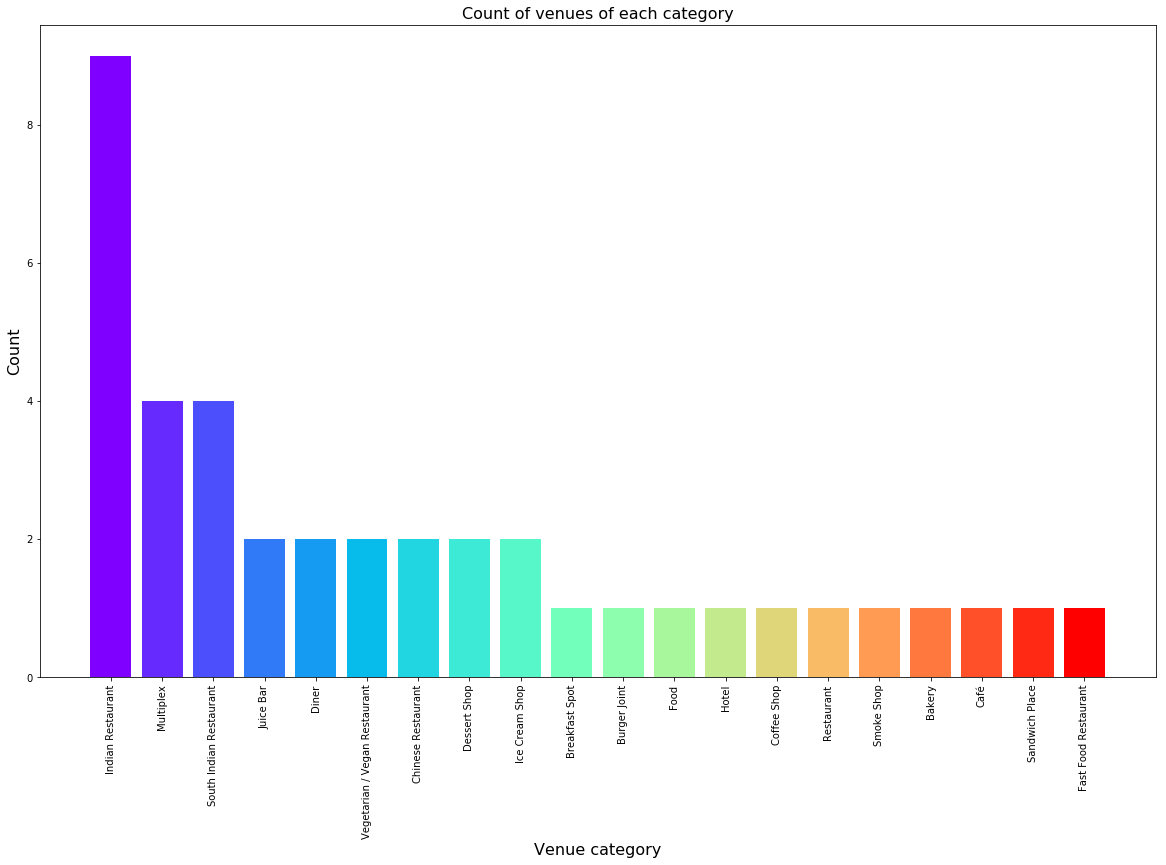

In [27]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are Cafe and Indian Restaurant. So, if as a tourist, you're looking for **Multiplexes and Indian restaurants**, you're in luck.

### Rating

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

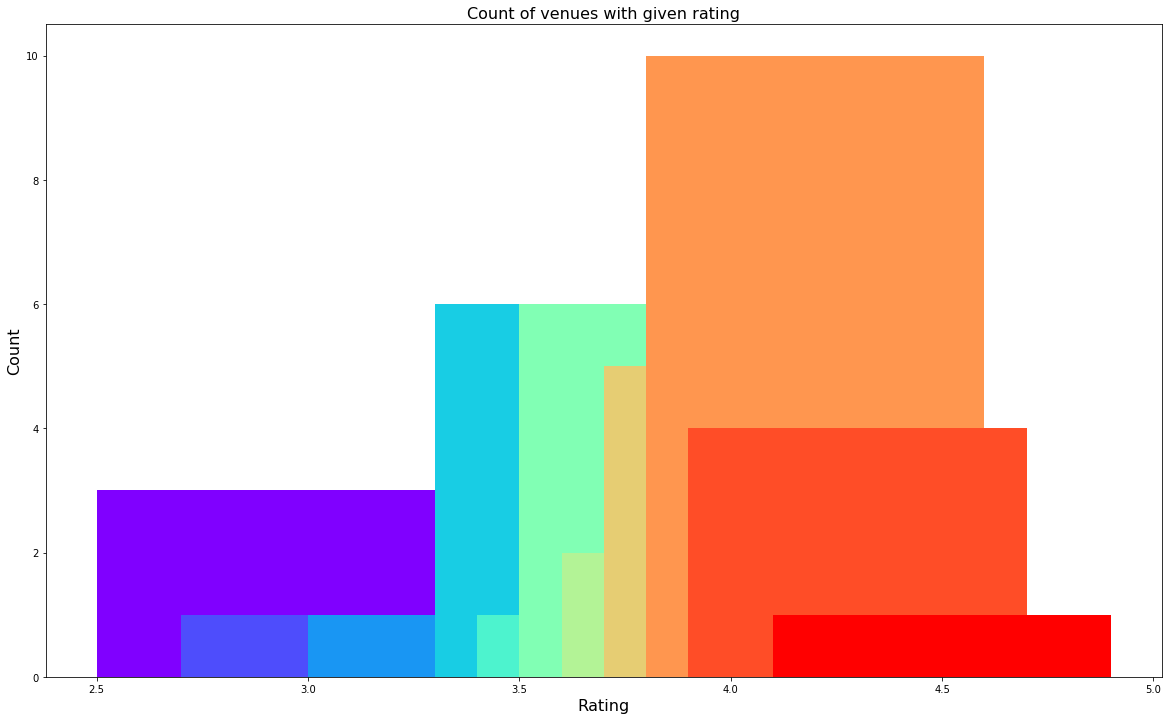

In [28]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that majority venues have their rating close to 4.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

 - 1 to 2
 - 2 to 3
 - 3 to 4
 - 4 to 5

In [29]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Now, we will plot the venues on the map.

In [30]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

hyderabad_map = folium.Map(location = [HYD_LATITUDE, HYD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(hyderabad_map)  

hyderabad_map.save("Venues Ratings.html")
hyderabad_map

The map has the location of all the venues. It appears that many venues are located near Himayat Nagar with rating above 3. If someone wants to explore new venues, they should definitely check out Abids and Himayat Nagar

### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

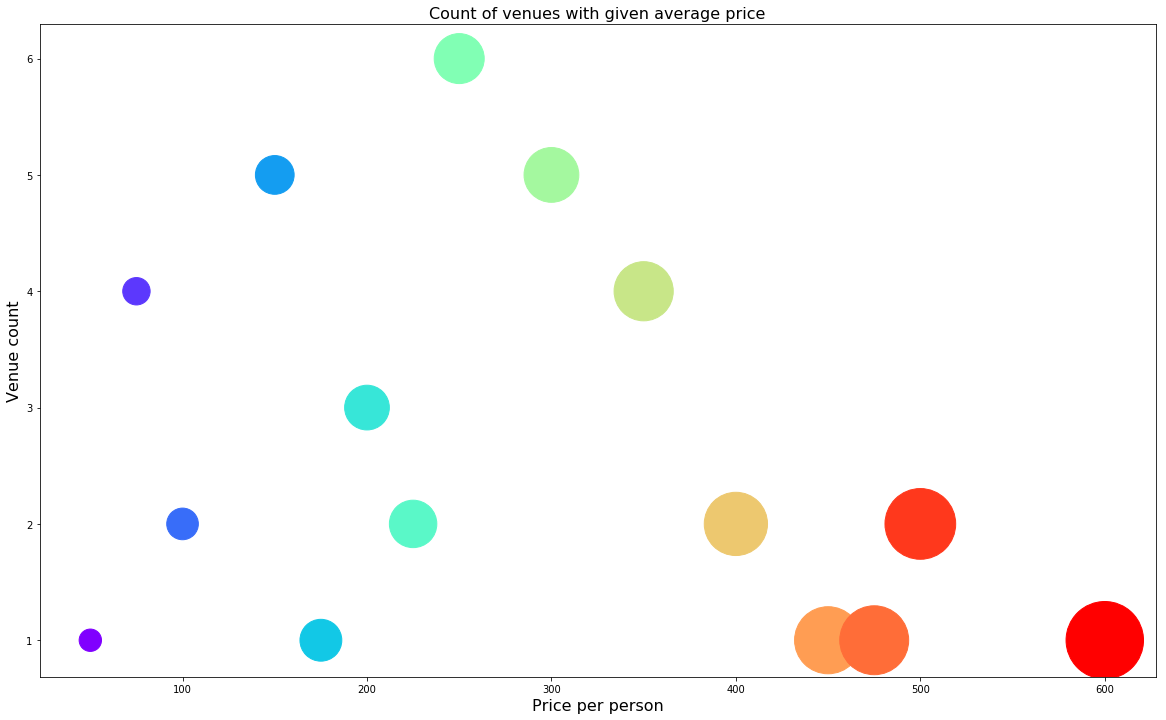

In [31]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price between Rs 200 and Rs 400.

Users might also be interested in going to a place that fits in their budget. I'll use the price_range column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [33]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

hyderabad_map = folium.Map(location = [HYD_LATITUDE, HYD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(hyderabad_map)  

hyderabad_map.save("Venues Prices.html")
hyderabad_map

 - The venues near Abids and Khairtabad are primarily lower priced.
 - The venues near Basheerbagh have steep prices.
 - Himayat Nagar seems to have a mix of both high priced and low priced venues.

### Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [34]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,South Indian Restaurant,Pragati Tiffin Center,17.3881,78.4813,1.0,4.3,"H V S Road, Hanuman Tekdi, Near Pargati Colleg...",75.0,Very good
1,0,Juice Bar,Mayur Pan House,17.3889,78.4806,1.0,4.2,"Plot 14, Near Arcade Complex, Boggulkunta Cros...",200.0,Very good
2,0,Indian Restaurant,Santosh Dhaba Exclusive,17.3884,78.4796,2.0,4.2,"8-2-629/1/2, Hanuman Tekdi, Near Hotel Jaya In...",250.0,Very good
3,0,Ice Cream Shop,Famous Ice Creams,17.3843,78.4748,1.0,4.3,"Mozamjahi Market, Near Old Goshamahal Trafic P...",75.0,Very good
4,0,Burger Joint,Bites Beyond Borders,17.4006,78.4886,1.0,3.8,"Street 10, Opposite TVS Shanti Nagar, The Lane...",200.0,Good


In [35]:
hyderabad_map = folium.Map(location = [HYD_LATITUDE, HYD_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(hyderabad_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(hyderabad_map)

hyderabad_map.save("Venues Clusters.html")
hyderabad_map

From the map, we see the two clusters:

 - The first cluster is spread across the whole city and includes the majority venues.
 - The second cluster is very sparsely spread and has very limited venues.

I'll also check the venues of the two clusters.

In [36]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,South Indian Restaurant,Pragati Tiffin Center,17.3881,78.4813,1.0,4.3,"H V S Road, Hanuman Tekdi, Near Pargati Colleg...",75.0,Very good
1,0,Juice Bar,Mayur Pan House,17.3889,78.4806,1.0,4.2,"Plot 14, Near Arcade Complex, Boggulkunta Cros...",200.0,Very good
2,0,Indian Restaurant,Santosh Dhaba Exclusive,17.3884,78.4796,2.0,4.2,"8-2-629/1/2, Hanuman Tekdi, Near Hotel Jaya In...",250.0,Very good
3,0,Ice Cream Shop,Famous Ice Creams,17.3843,78.4748,1.0,4.3,"Mozamjahi Market, Near Old Goshamahal Trafic P...",75.0,Very good
4,0,Burger Joint,Bites Beyond Borders,17.4006,78.4886,1.0,3.8,"Street 10, Opposite TVS Shanti Nagar, The Lane...",200.0,Good
5,0,Indian Restaurant,KFC,17.4015,78.4858,1.0,4.1,"Shop 002, 3-6-196/197, Prime Plaza, Himayath N...",225.0,Very good
6,0,Dessert Shop,Almond House,17.4012,78.4859,1.0,4.2,"Lingapur Building, Himayath Nagar, Hyderabad",150.0,Very good
7,0,South Indian Restaurant,Laxman Ki Bandi,17.3790,78.4641,1.0,4.2,"Near Mangalhat Road, Gyan Bagh Colony, Nampall...",50.0,Very good
8,0,Café,New Niloufer Cafe & Restaurant,17.3996,78.4628,2.0,3.9,"Red Hills, Near Niloufer Hospital, Lakdikapul,...",250.0,Good
9,0,Indian Restaurant,Chinese Fast Food,17.4065,78.4978,1.0,2.9,"RTC Cross Roads, Opposite Bawarchi, Nallakunta...",100.0,Okay


In [37]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.25 and rating spread around 3.95


In [38]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Diner,Hotel Shadab,17.3688,78.4755,2.0,4.2,"Plot 21, Opposite Madina Circle, High Court Ro...",450.0,Very good
1,1,Indian Restaurant,Cafe Bahar,17.3996,78.4786,2.0,4.5,"3-5-815/A, Hyderguda, Basheer Bagh, Hyderabad",300.0,Very good
2,1,Hotel,Taj Mahal - Taj Mahal Hotel,17.3920,78.4769,2.0,4.1,"4-1-999, Abids Road, Abids, Hyderabad",350.0,Very good
3,1,Diner,New Santosh Dhaba,17.3912,78.4775,2.0,3.9,"Plot 969 & 970, Ahuja Estate, Tilak Road, Abid...",350.0,Good
4,1,Indian Restaurant,Blue Fox,17.4013,78.4858,3.0,3.9,"3-6-199/1, Himayath Nagar, Hyderabad",600.0,Good
5,1,Chinese Restaurant,Chung Hua Restaurant,17.4055,78.4762,2.0,3.9,"5-9-29G, 1, Hira Mansion, Opposite Paigah Plaz...",350.0,Good
6,1,Chinese Restaurant,Ohri's Eatmor OCC,17.4049,78.4766,3.0,4.2,"5-9-30/16-20, Ohri's Cuisine Court, Opposite O...",500.0,Very good
7,1,Indian Restaurant,Paradise Biryani,17.4124,78.4653,2.0,4.2,"NTR Gardens, Near Prasads IMAX, Saifabad, Neck...",475.0,Very good
8,1,Indian Restaurant,Sagar Papaji Ka Dhaba,17.3883,78.4792,2.0,4.2,"Plot 4-1-365/F/1, Reddy Hostel Road, Hanuman T...",400.0,Very good
9,1,Ice Cream Shop,Ohri's Eatmor OCC,17.4049,78.4766,3.0,4.2,"5-9-30/16-20, Ohri's Cuisine Court, Opposite O...",500.0,Very good


In [39]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 2.19 and rating spread around 3.87


### Results and Discussion 

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of hyderabad, India.

After collecting data from the **Foursquare** and **Zomato APIs**, we got a list of 107 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 40.

We identified that from the total set of venues, majority of them were **Multiplexes** and **Indian Restaurants**. A visitor who loves Multiplexes/Indian Restaurants would surely benefit from coming to Hyderabad.

While the complete range of ratings range from 1 to 5, the **majority venues have ratings close to 3.8**. This means that most restaurants provide **good quality food** which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there are clusters of venues around **Himayat Nagar and Abids**. These clusters also have **very high ratings (more than 3)**.

When we take a look at the price values of each venue, we explore that many venues have prices which are in the **range of Rs 200 to Rs 400 for one person**. However, the variation in prices is not very large, given the complete range starts from Rs 100 and goes uptil Rs 600. On plotting the venues based on their price range on the map, we discovered that venues located near **Abids and Khairtabad are relatively priced lower than venues in Himayat Nagar.**

Finally, through clusters we identified that there are **many venues** which are **relatively lower priced but have an average rating of 3.87.** On the other hand, there are few venues which are **high priced and have average rating of 3.95.**

 - If you're looking for cheap places with relatively high rating, you should check **Khairtabad.**
 - If you're looking for the best places, with the highest rating but might also carry a high price tag, you should visit **Himayat Nagar.**
 - If you're looking to explore the city and have no specific criteria to decide upon the places you want to visit, you should try **Abids.**

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

The purpose of this project was to explore the places that a person visiting Hyderabad could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are three major areas a person can visit: Khairtabad, Himayat Nagar, Abids. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.